In [1]:
from gen.sample_generator import data_generator, stock_data_generator, stacked_data_generator
import numpy as np

# df = stacked_data_generator(start_date=(2023,1,1),
#                     end_date=(2023,2,2),
#                     perc_anomalies=0.08,
#                     regenerate=False
#                     )

df = stock_data_generator(start_date=(2023,1,1),
                    end_date=(2023,2,2),
                    perc_anomalies=0.08,
                    regenerate=False
                    )

Loading from filesystem c:\Users\manoj\Documents\MANOJ\Github\ML_PyTorch\data\stock_start_23_01_01_end_23_02_02_freq_5T_perc_0.08.csv


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9217 entries, 2023-01-01 00:00:00 to 2023-02-02 00:00:00
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   stock_1  9217 non-null   float64
 1   stock_2  9217 non-null   float64
dtypes: float64(2)
memory usage: 216.0 KB


In [3]:
df.head()

,stock_1,stock_2
datetime,,
2023-01-01 00:00:00,2.377889,0.032361
2023-01-01 00:05:00,2.227047,-0.807202
2023-01-01 00:10:00,2.022227,-1.426083
2023-01-01 00:15:00,1.799659,-1.836901
2023-01-01 00:20:00,1.595574,-2.052274


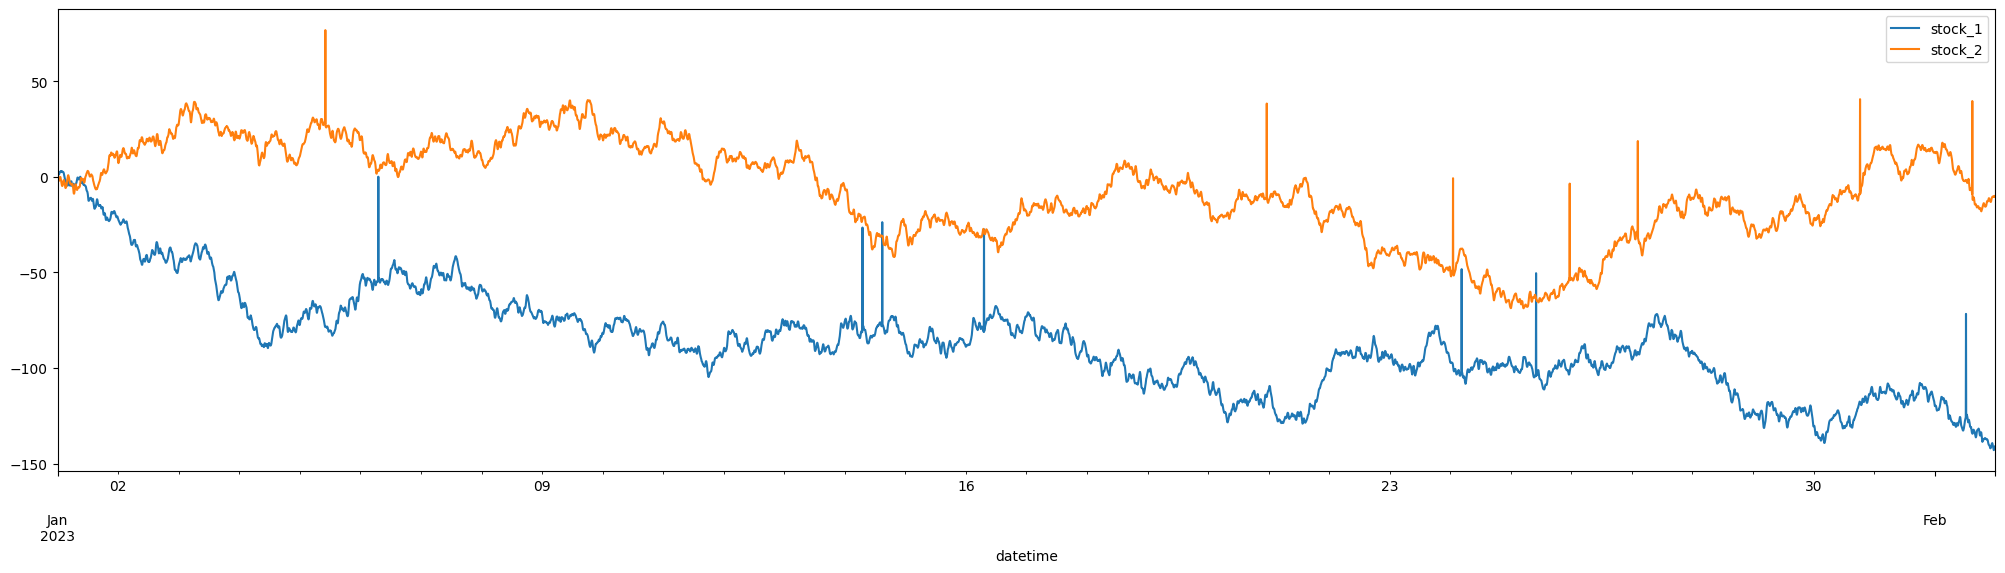

In [4]:
if 'dimension' in df.columns.to_list():
    df[df.dimension=='C'].plot(figsize=(25,6))
else:
    df.plot(figsize=(25,6))

In [5]:
selected_columns = df.columns.to_list()
if 'dimension' in df.columns.to_list():
    selected_columns.remove('dimension')

In [6]:
# Function to create windowed sequences
def create_windows(data, window_size, stride=1):
    X, y = [], []
    for i in range(0, len(data) - window_size, stride):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)
    
    
# Calculate overall mean and std
all_metrics_data = df[selected_columns].to_numpy()

overall_mean, overall_std = np.mean(all_metrics_data, axis=0), np.std(all_metrics_data, axis=0)

In [7]:
# List to store windowed and normalized data for all cell_ids
X_list, y_list = [], []

window_size = 24

if 'dimension' in df.columns.to_list():
    for dim, group in df.groupby('dimension'):
        
        group = group.sort_index()
        # Select only the columns containing the metrics
        metrics_data = group[selected_columns].to_numpy()

        # Normalize the data using the overall mean and std
        metrics_data_normalized = (metrics_data - overall_mean) / overall_std

        # Create windowed sequences
        X_window, y_window = create_windows(metrics_data_normalized, window_size, stride=2)

        # Append to the list
        X_list.append(X_window)
        y_list.append(y_window)
else:
    metrics_data = df[selected_columns].to_numpy()

    # Normalize the data using the overall mean and std
    metrics_data_normalized = (metrics_data - overall_mean) / overall_std

    # Create windowed sequences
    X_window, y_window = create_windows(metrics_data_normalized, window_size, stride=2)

    # Append to the list
    X_list.append(X_window)
    y_list.append(y_window)

In [8]:
X_list = np.concatenate(X_list)
y_list = np.concatenate(y_list)

In [9]:
print(X_list.shape)
print(y_list.shape)

(4597, 24, 2)
(4597, 2)


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim

In [11]:
# Split the data into training and validation sets.
split_ratio = 0.8
split_index = int(len(X_list) * split_ratio)
X_train, y_train = X_list[:split_index], y_list[:split_index]
X_val, y_val = X_list[split_index:], y_list[split_index:]
print(X_train.shape)
print(y_train.shape)

(3677, 24, 2)
(3677, 2)


In [12]:
# Step 2: Define a PyTorch Dataset and DataLoader
from torch.utils.data import DataLoader, random_split, TensorDataset
from prediction.nn_models import TimeSeriesDataset

batch_size = 128

train_dataset = TimeSeriesDataset(X_train, y_train,'Train',window_size=window_size, output_size=len(selected_columns))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

val_dataset = TimeSeriesDataset(X_val,y_val,'Validation', window_size=window_size, output_size=len(selected_columns))
val_loader = DataLoader(val_dataset,batch_size=batch_size, shuffle=True)

In [13]:
# Reduced model hyperparameters
d_model = len(selected_columns)
nhead = 2  # reduced from 2
num_layers = 2  # reduced from 3
dim_feedforward = 64  # reduced from 128
#batch_size = 32  # reduced from 64

from prediction.nn_models import LSTM_TimeSeriesModel_2
# Initialize the reduced Model, Loss, and Optimizer
# Now we can create a model and send it at once to the device
model = LSTM_TimeSeriesModel_2(d_model, nhead, d_model)

# model = TransformerTimeSeriesModel(d_model, nhead, num_layers, dim_feedforward)

loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=0.001)
# print(model.state_dict())

In [14]:
from prediction.genericReg import *

sbs = StepByStep(model, loss_fn, optimizer)
sbs.set_loaders(train_loader,val_loader)
sbs.set_tensorboard('Anomaly')
sbs.add_graph()
sbs.train(n_epochs=200, print_every=20)
sbs.save_checkpoint('model/model_checkpoint.pth')

# print(model.state_dict())

Epoch [20/200]	Training-Loss: 0.6628	Validation-Loss: 0.9824
Epoch [40/200]	Training-Loss: 0.3437	Validation-Loss: 0.8149
Epoch [60/200]	Training-Loss: 0.2303	Validation-Loss: 0.6348
Epoch [80/200]	Training-Loss: 0.1688	Validation-Loss: 0.5788
Epoch [100/200]	Training-Loss: 0.1307	Validation-Loss: 0.5252
Epoch [120/200]	Training-Loss: 0.1067	Validation-Loss: 0.4870
Epoch [140/200]	Training-Loss: 0.0899	Validation-Loss: 0.4352
Epoch [160/200]	Training-Loss: 0.0766	Validation-Loss: 0.3754
Epoch [180/200]	Training-Loss: 0.0649	Validation-Loss: 0.3544
Epoch [200/200]	Training-Loss: 0.0541	Validation-Loss: 0.2921


In [15]:
# %tensorboard --port 7000 --logdir runs

In [16]:
model.eval()
all_reconstruction_errors = []

for batch_idx, (X_batch, y_batch) in enumerate(val_loader):
    with torch.no_grad():
        y_pred = sbs.predict(X_batch)
        reconstruction_error = ((y_batch.cpu() - y_pred) ** 2).mean(dim=1).numpy()
        all_reconstruction_errors.extend(reconstruction_error)

all_reconstruction_errors = np.array(all_reconstruction_errors)

In [17]:
import os
reconstruction_checkpt_file = 'all_reconstruction_error.npy'  # Define the path where you want to save the checkpoint
reconstruction_checkpt_file_path = os.path.abspath(os.path.join(os.getcwd(), 'model', reconstruction_checkpt_file))

np.save(reconstruction_checkpt_file_path, all_reconstruction_errors)

In [18]:
import pandas as pd
# Create bins 
bin_ranges = pd.cut(all_reconstruction_errors, bins=50)

# Count the frequency of each bin
bin_counts = bin_ranges.value_counts().sort_index()

# Create a Pandas DataFrame for better visualization
table = pd.DataFrame({
    'Bin_Range': bin_counts.index.astype(str),
    'Frequency': bin_counts.values
})

# Print the table
print(table)

             Bin_Range  Frequency
0   (-0.00191, 0.0389]        266
1     (0.0389, 0.0778]         20
2      (0.0778, 0.117]         18
3       (0.117, 0.156]         17
4       (0.156, 0.195]         28
5       (0.195, 0.233]         45
6       (0.233, 0.272]         64
7       (0.272, 0.311]         76
8        (0.311, 0.35]         70
9        (0.35, 0.389]         45
10      (0.389, 0.428]         26
11      (0.428, 0.467]         35
12      (0.467, 0.506]         16
13      (0.506, 0.545]         15
14      (0.545, 0.584]         17
15      (0.584, 0.622]         34
16      (0.622, 0.661]         19
17        (0.661, 0.7]         23
18        (0.7, 0.739]         14
19      (0.739, 0.778]         13
20      (0.778, 0.817]         21
21      (0.817, 0.856]         14
22      (0.856, 0.895]          2
23      (0.895, 0.934]          1
24      (0.934, 0.972]          0
25      (0.972, 1.011]          3
26       (1.011, 1.05]          6
27       (1.05, 1.089]          4
28      (1.089

In [19]:
threshold = np.percentile(all_reconstruction_errors, 99.9)
threshold

1.8414754877090602

Perform the prediction on the entire dataset now for one of the dimension if it is present

In [20]:
if 'dimension' in df.columns.to_list():
    
    df_ml = df.loc[df['dimension']=='B']
    df_ml = df_ml.sort_index()
else:
    df_ml = df

In [21]:

new_metrics_data = df_ml[selected_columns].to_numpy()

# Using `create_windows` function to create windowed sequences
new_X_window, new_y_window = create_windows(new_metrics_data, window_size)

# Step 4: Normalize the windowed data using original mean and std
new_X_window_normalized = (new_X_window - overall_mean) / overall_std
new_y_window_normalized = (new_y_window - overall_mean) / overall_std



# Create DataLoader if needed
new_dataset = TimeSeriesDataset(new_X_window_normalized, new_y_window_normalized,'All data', window_size=window_size, output_size=len(selected_columns))
new_loader = DataLoader(new_dataset, batch_size=batch_size, shuffle=False)



In [22]:
model.eval()
anomalies = []
filt_reconstruction_errors = []

for batch_idx, (X_batch, y_batch) in enumerate(new_loader):  # Replace val_loader with your test_loader if using new data
    with torch.no_grad():
        y_pred = sbs.predict(X_batch)
        reconstruction_error = ((y_batch.cpu() - y_pred) ** 2).mean(dim=1).numpy()
        
        filt_reconstruction_errors.extend(reconstruction_error)
        batch_anomalies = reconstruction_error > threshold
        anomalies.extend(batch_anomalies)

filt_reconstruction_errors = np.array(filt_reconstruction_errors)
anomalies = np.array(anomalies)
num_anomalies = np.sum(anomalies)
print(f"Number of anomalies: {num_anomalies}")

Number of anomalies: 10


In [23]:
#Here we calculate the number of anomalies based on the pre-calculated Anomaly score (reconstruction_errors)
anomalies_o = filt_reconstruction_errors > threshold
num_anomalies_o = np.sum(anomalies_o)
print(f"Number of anomalies: {num_anomalies_o}")

Number of anomalies: 10


## Visualize the Anomalies detected on the original data

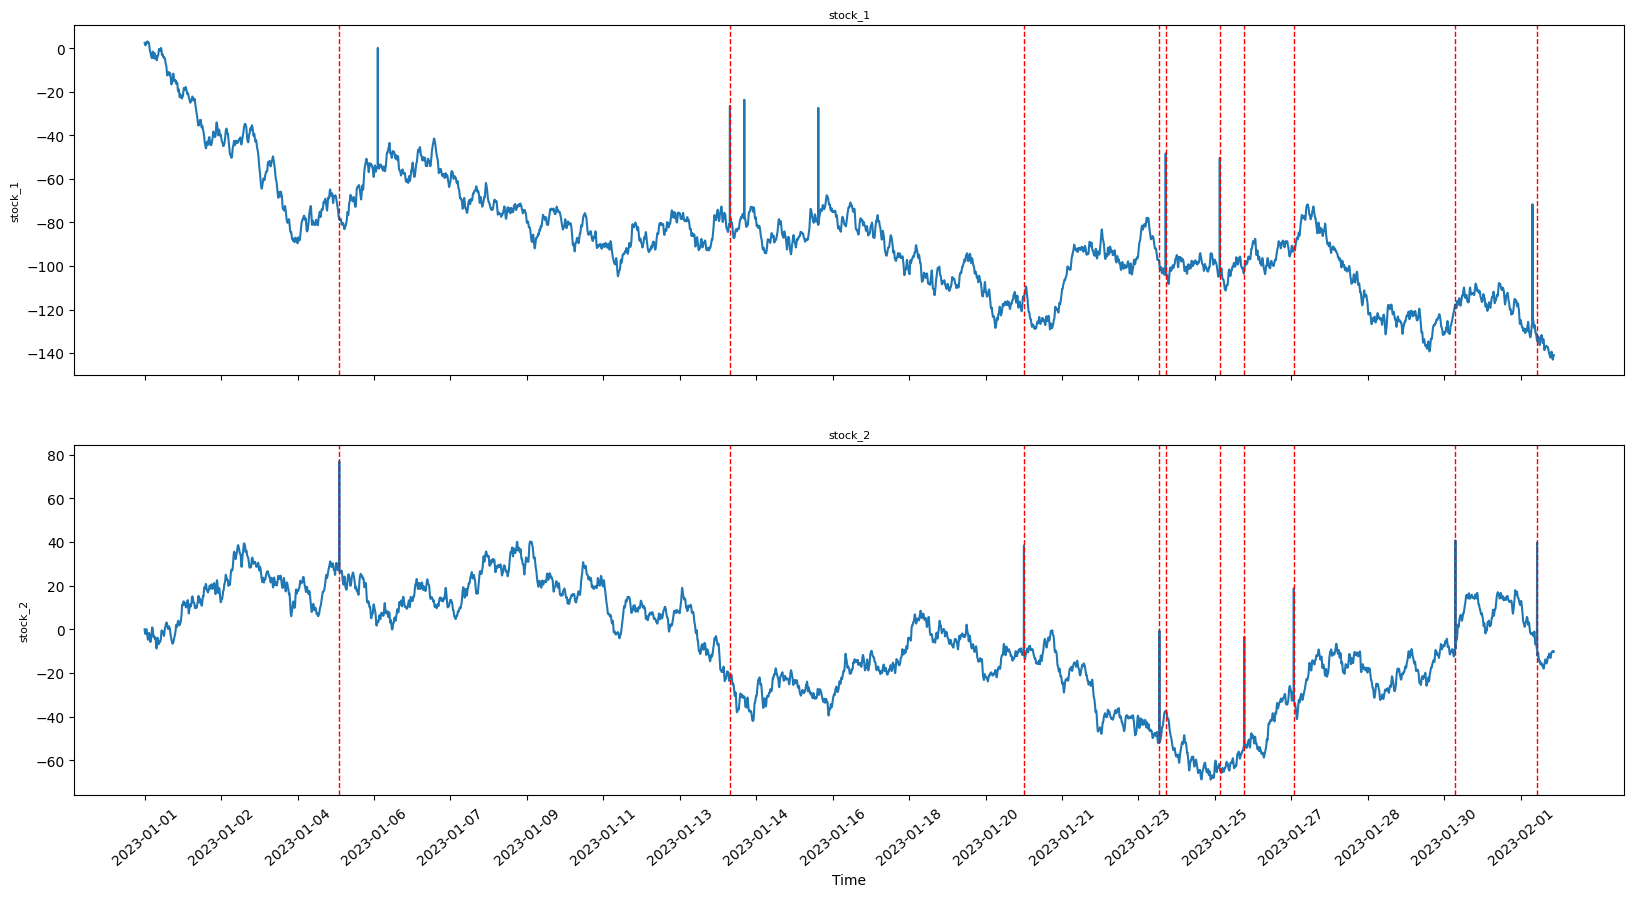

In [24]:

import matplotlib.pyplot as plt

# Prepare anomaly indices (same as previous examples)
anomalous_indexes_val = np.where(anomalies_o)[0]
original_anomalous_indexes = anomalous_indexes_val + window_size
anomaly_times = df_ml.index[original_anomalous_indexes]

# Metrics to be plotted
metrics = selected_columns

# Create subplots
fig, axes = plt.subplots(len(metrics), 1, figsize=(20, 10), sharex=True)

# Loop through metrics and plot
for i, metric in enumerate(metrics):
    axes[i].plot(df_ml.index, df_ml[metric], label=f'{metric} Data')
    #axes[i].scatter(anomaly_times, pm_data[metric].iloc[original_anomalous_indexes], color='red', label='Anomaly')
    axes[i].set_title(f'{metric}',fontsize=8)
    axes[i].set_ylabel(metric ,fontsize=8)
    for anomaly_time in anomaly_times:
        axes[i].axvline(x=anomaly_time, color='red', linestyle='--', linewidth=1, label='Anomaly')
    #axes[i].legend()


# Label the shared x-axis
axes[-1].set_xlabel('Time')
ticks_to_use = df_ml.index[::500]  # Choose every 10th time point
plt.xticks(ticks_to_use)
plt.xticks(rotation=40)

# Show plot
plt.show()

## Export the model

In [25]:
sample_input = torch.randn(1, window_size, len(selected_columns))
torch.onnx.export(model,
                  sample_input.to(torch.device('cuda')),
                  'model/model_onnx.onnx',
                  export_params=True,
                  do_constant_folding=True,
                  input_names=['input'],
                  output_names=['output'],
                  dynamic_axes={'input': {0: 'window_size'}, 
                                'output': {0: 'window_size'}}
                  )

c:\Users\manoj\Documents\MANOJ\Github\ML_PyTorch\venv\lib\site-packages\torch\onnx\symbolic_opset9.py:4662: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(


In [26]:
# Export metadata
import json

data = {
    'window_size': window_size,
    'selected_columns': selected_columns,
    'overall_mean': overall_mean.tolist(),
    'overall_std': overall_std.tolist()
    }
with open('model/model_data.json', 'w') as f:
    json.dump(data, f)